## Implement homogeneous to inhomogeneous transformation as described in 
## "Spectral Solution with a Subtraction Method to Improve Accuracy"
### Matthew Green
### Santa Clara University

In [34]:
import numpy as np  
import scipy
import matplotlib.pyplot as plt 

def fDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s))
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (j * dx)**k / np.math.factorial(k)

    return mat 

def bDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s))
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (-j * dx)**k / np.math.factorial(k)

    return mat 

def fDiffVec(order, f): 
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j-1] = f[j] - f[0]
    return diff 

def bDiffVec(order, f): 
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j-1] = (f[-1-j] - f[-1])
    return diff 


def iterativeRefinement(A, b, tolerance = 1e-9): 
    C = np.linalg.solve(A, b) 
    residual      = b - A @ C
    residualError = np.sum(np.abs(residual)) 

    iteration = 0
    while residualError > tolerance:
        correction = np.linalg.solve(A, residual) 
        C += correction
        residual = b - A @ C
        residualError = np.sum(np.abs(residual)) 
        iteration += 1
        #print(f"After {iteration} iterations with residual error {residualError}")
        if iteration > 100:
            break

    #print(f"Finished in {iteration} iterations with residual error {residualError}")
    return C 

x = np.linspace(0, 2, 100)
f = np.exp(x)
xeval = shiftx(x)
dx = xeval[1] - xeval[0]

order = 9
A = fDiffMat (order, dx) 
b = fDiffVec (order, f)

Dl = iterativeRefinement(A, b)

A = bDiffMat (order, dx) 
b = bDiffVec (order,  f)

Dr = iterativeRefinement(A, b)
Dl, Dr

(array([ 2.00000000e+00,  4.00000000e+00,  8.00000002e+00,  1.59999959e+01,
         3.20006727e+01,  6.39205732e+01,  1.34425078e+02, -6.55328930e+01,
         8.07270795e+03]),
 array([ 1.47781122e+01,  2.95562244e+01,  5.91124485e+01,  1.18224842e+02,
         2.36440748e+02,  4.71852489e+02,  8.62852866e+02, -2.16996044e+03,
        -8.96103742e+04]))

In [16]:
def cosineDiffVec(order, f, Dl, Dr):
    b = np.zeros(2*order) 
    b[0] = f[ 0]
    b[1] = f[-1]
    for i in range(1, order): 
        b[i*2    ] = Dl[i]/(np.pi)**(2*i) 

    for i in range(1, order): 
        b[i*2 + 1] = Dr[i]/(np.pi)**(2*i) 

    return b 

def cosineDiffMat(order): 
    A = np.zeros((order*2, order*2))
    for i in range(order): 
        derivative  = 2 * i 
        for j in range(1, 2*order+1):
            #Every derivative gives a factor of j -- j**derivative
            #Every second derivative gives a minus sign -- (-1)**i 
            #Cosine evaluated at pi gives negative sign depending on wavelength -- (-1)**j
            A[2*i  , j-1] = j**derivative * (-1)**i
            A[2*i+1, j-1] = j**derivative * (-1)**i * (-1)**j 

    return A


def shiftx(x):
    return (x - x[0])/(x[-1] - x[0])

def reconstruct(C, x, derivative_order = 0):
    f = np.zeros(x.shape) 
    L = x[-1] - x[0]
    xeval = shiftx(x) 
    for k in range(1, len(C) + 1):
        f += C[k-1] * np.real((1j * k * np.pi * L) ** derivative_order * np.exp(1j * k * np.pi * xeval))

    return f


def getShiftFunction(f, order, x): 
    xeval = shiftx(x) 
    dx = xeval[1] - xeval[0]
    A = fDiffMat (order, dx) 
    b = fDiffVec (order, f)
    Dl = iterativeRefinement(A, b)

    A = bDiffMat (order, dx) 
    b = bDiffVec (order,  f)

    Dr = iterativeRefinement(A, b)

    A = cosineDiffMat(int(order/2) + 1) 
    b = cosineDiffVec(int(order/2) + 1, f, Dl, Dr)
    C = iterativeRefinement(A, b)


    shift = reconstruct(C, xeval)
    return shift, C, xeval


def antisymmetricExtension(f, debug=False):
    fext = np.concatenate([f, -np.flip(f)[1:-1]])
    if debug: 
        plt.title("First derivative")
        plt.plot(np.roll(fext, -1) - fext)
        plt.show()
        plt.title("Second derivative")
        plt.plot(np.roll(fext, -1) - 2 * fext + np.roll(fext, 1))
        plt.show()
    return fext 

order = 5
A = cosineDiffMat(order) 
b = cosineDiffVec(order, f, Dl, Dr)
C = iterativeRefinement(A, b)


After 1 iterations with residual error 1.1641447766712332e-09
After 2 iterations with residual error 7.354936143628976e-10
Finished in 2 iterations with residual error 7.354936143628976e-10


In [17]:
shift = reconstruct(C, x)

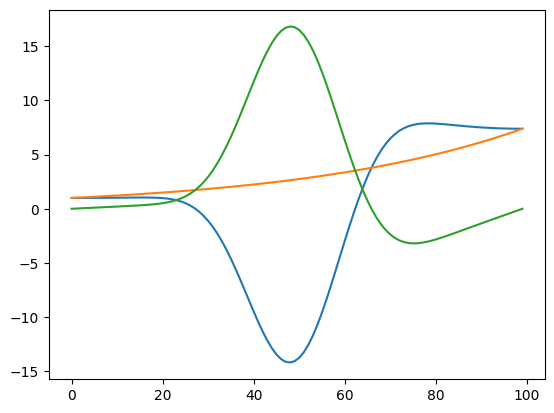

In [5]:
plt.plot(shift)
plt.plot(f)
plt.plot(f - shift)

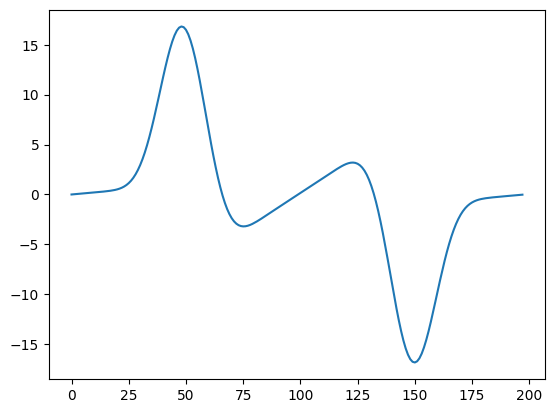

In [6]:
fext = np.concatenate([f - shift, -np.flip(f - shift)[1:-1]])
plt.plot(fext)

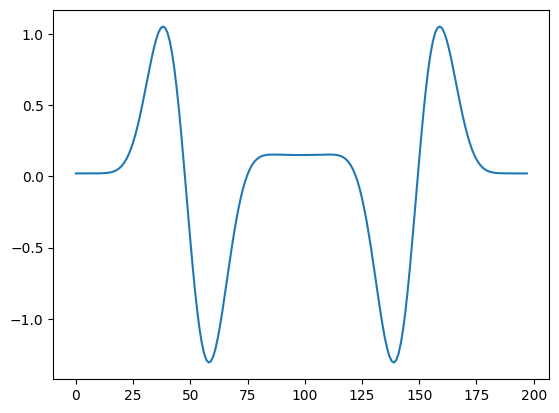

In [7]:
plt.plot(np.roll(fext, -1) - fext)

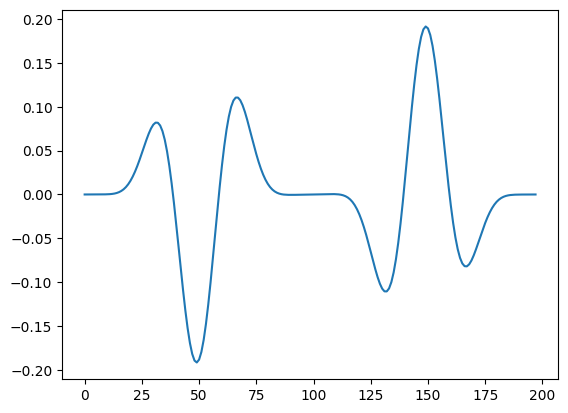

In [8]:
plt.plot(np.roll(fext, -1) - 2 * fext + np.roll(fext, 1))

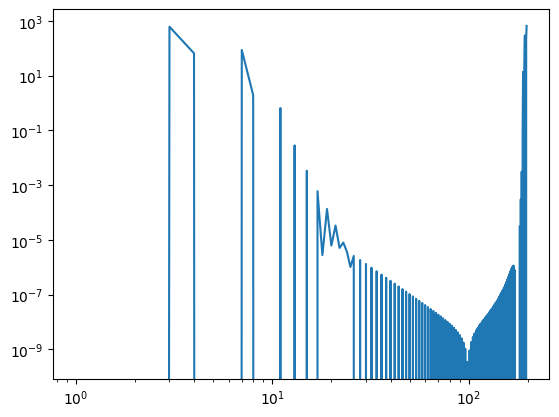

In [9]:
fhat = scipy.fft.fft(fext)
plt.loglog(fhat.imag)

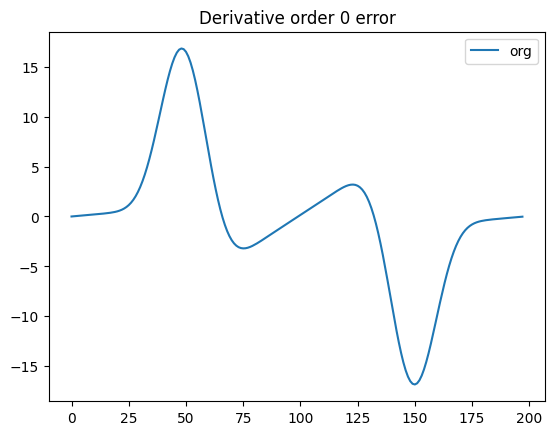

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

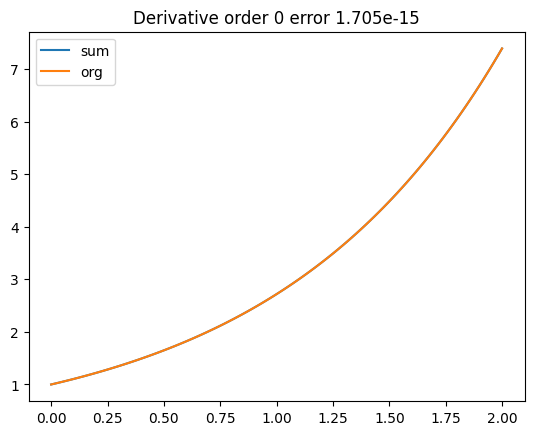

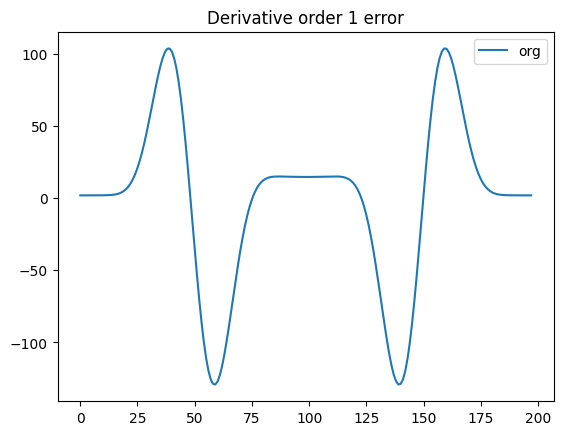

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

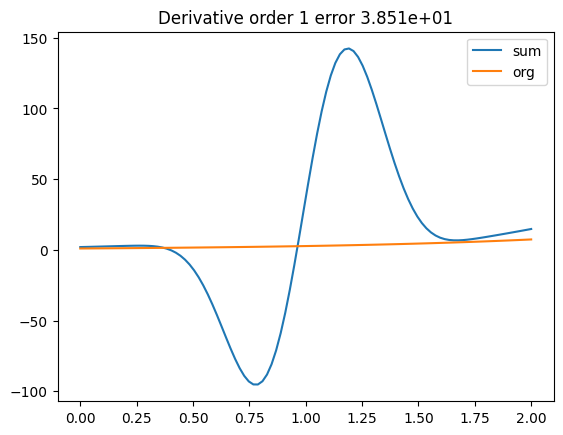

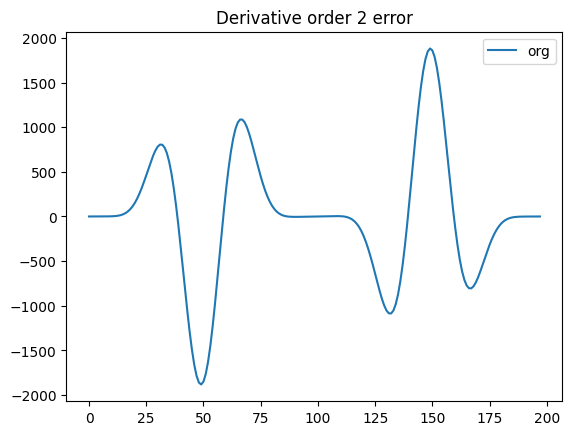

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

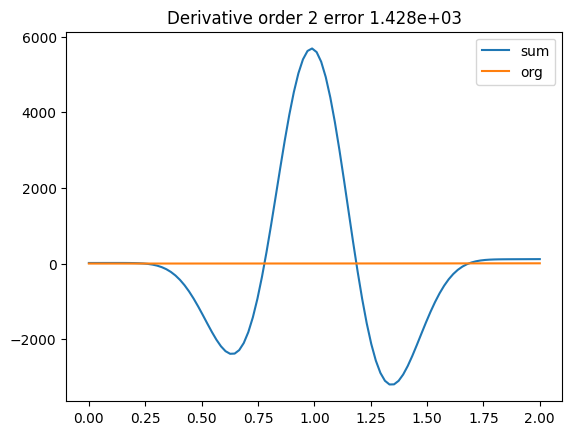

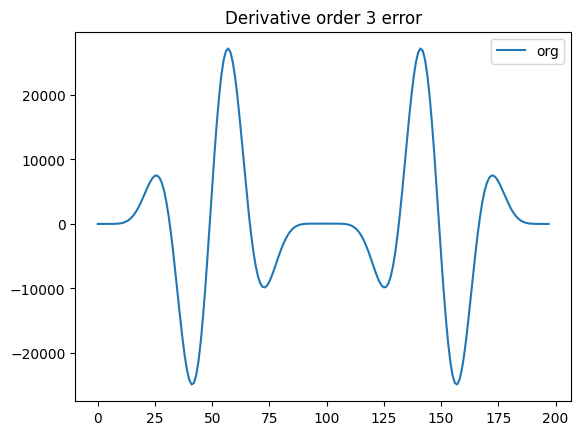

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

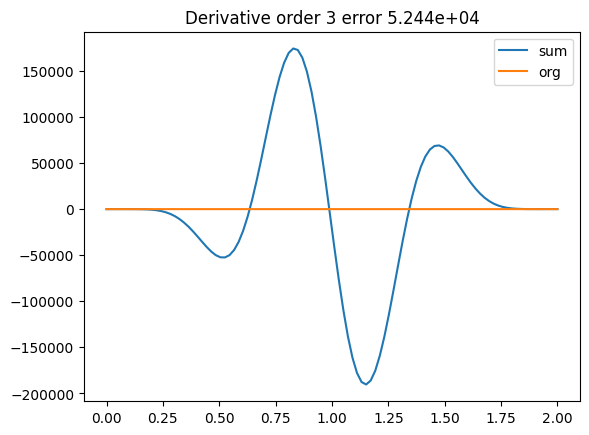

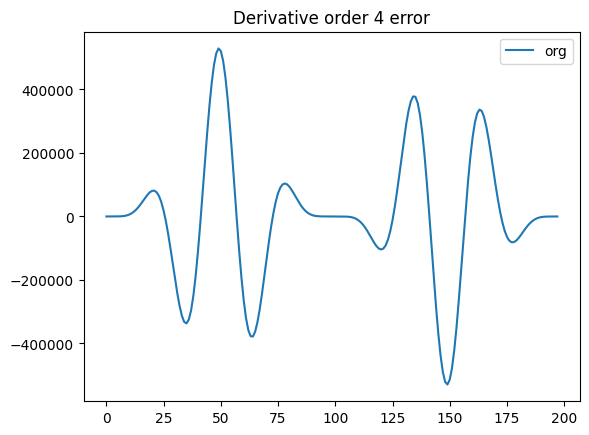

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

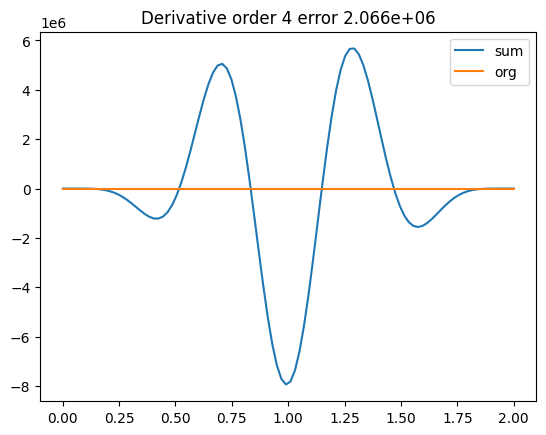

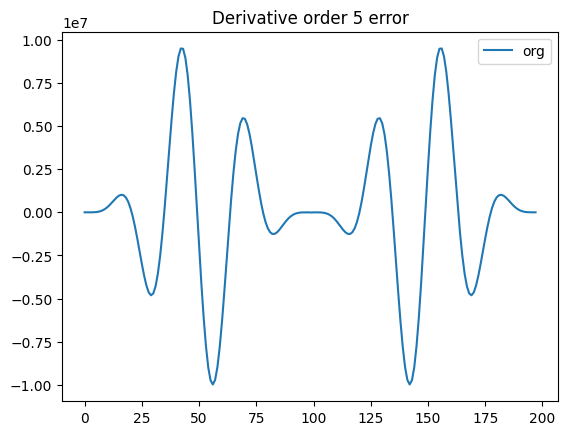

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

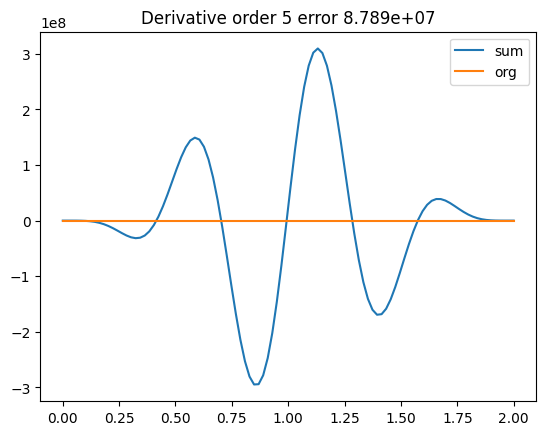

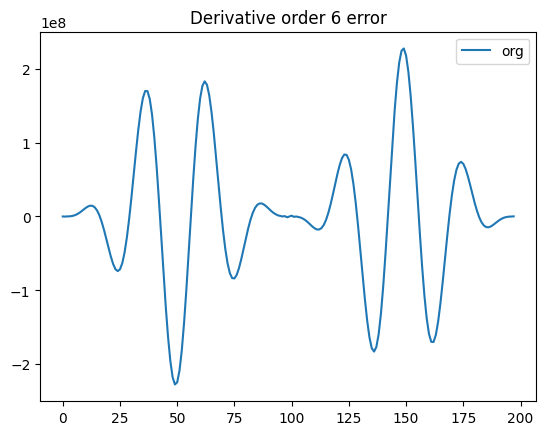

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

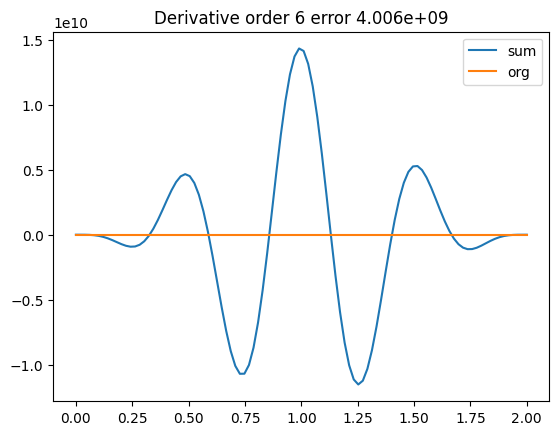

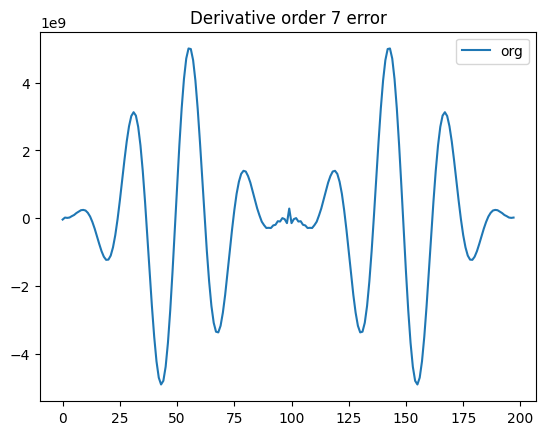

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

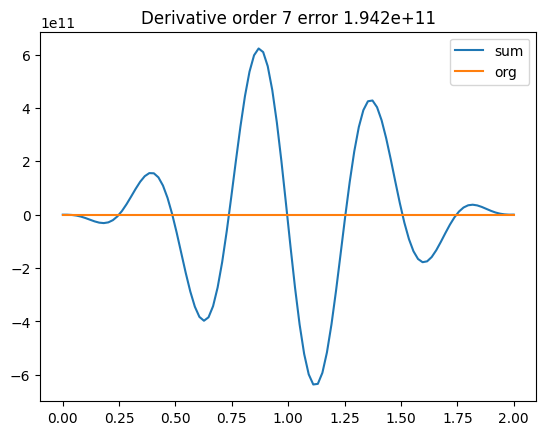

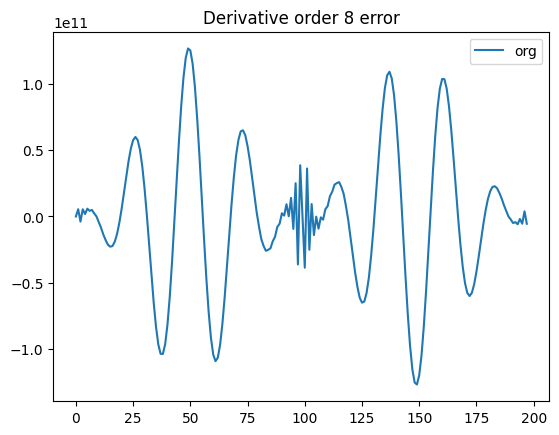

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

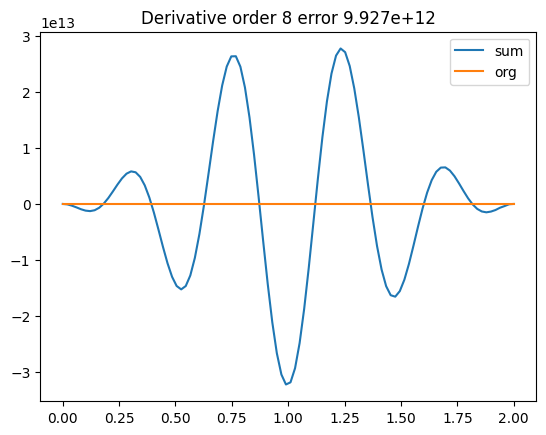

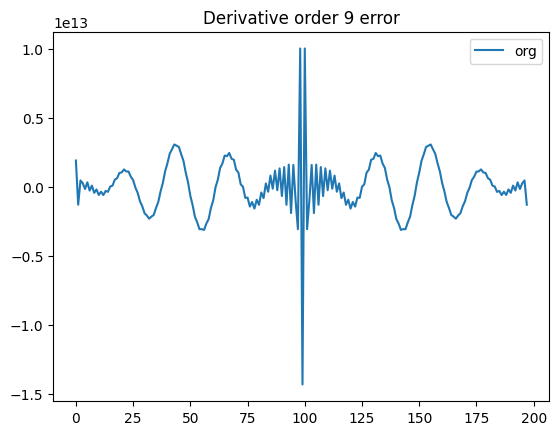

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

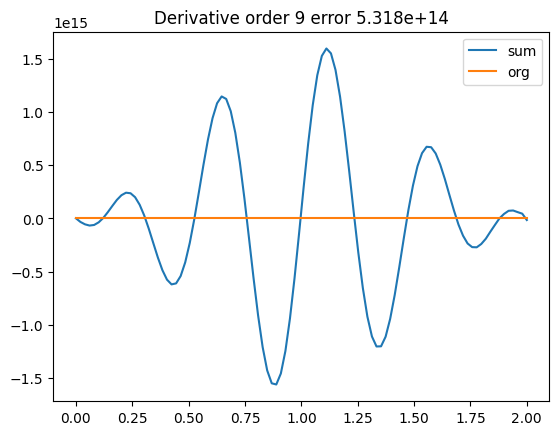

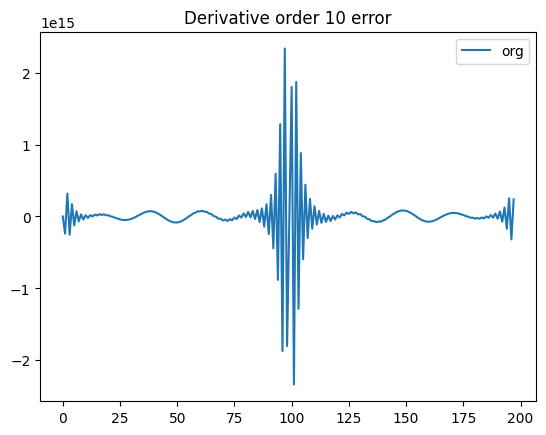

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

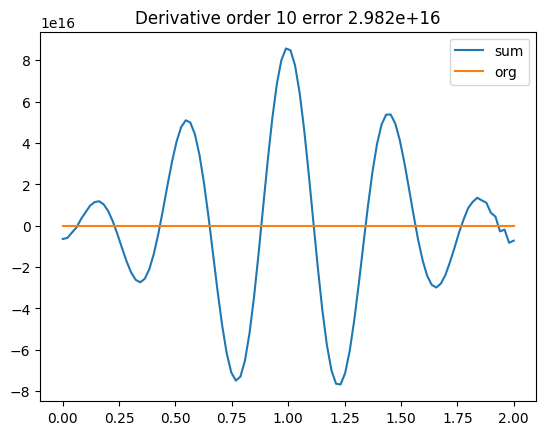

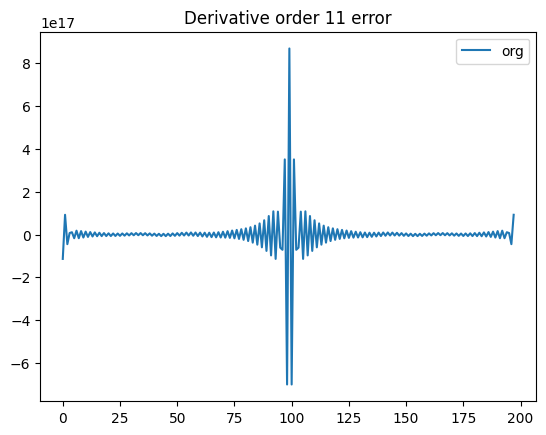

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

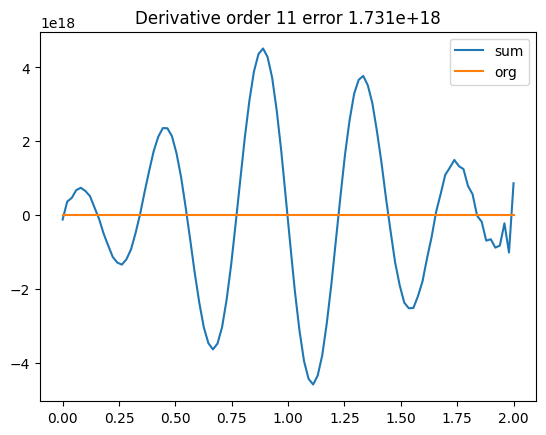

In [10]:

def getk(p): 
    N = len(p) 
    L = len(p) * dx
    k = 2 * np.pi/ L * np.arange(-N/2, N/2)
    return np.fft.ifftshift(k) 

k = getk(fhat) 

for i in range(12): 
    forg = np.exp(x)
    frec = scipy.fft.ifft(fhat * (1j*k)**i)
    plt.title(f"Derivative order {i} error")
    plt.plot(frec.real, label="org") 
    plt.legend()
    plt.show()
    frec = frec.real[:100]
    reco = reconstruct(C, x, i)
    sumo = frec + reco 
    plt.title(f"Derivative order {i} error {np.mean(np.abs(sumo-forg)):3.3e}")
    #plt.plot(x, frec, label="rec") 
    #plt.plot(x, reco, label="reco") 
    plt.plot(x, sumo, label="sum") 
    plt.plot(x, forg, label="org") 
    plt.legend()
    plt.show() 

## Test decay of Fourier coefficients

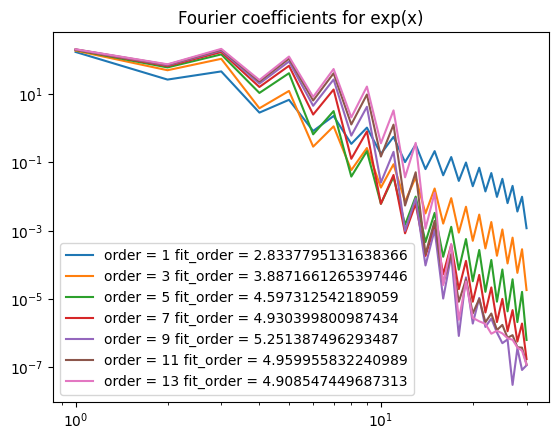

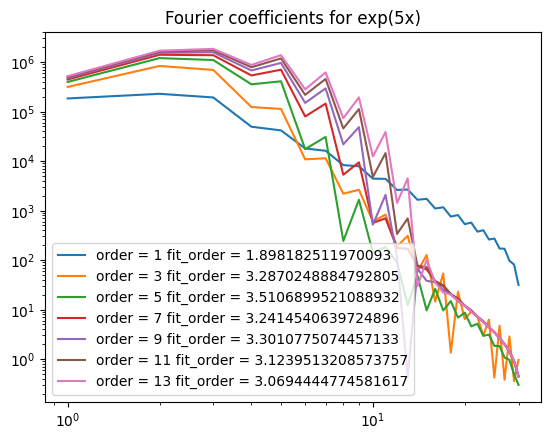

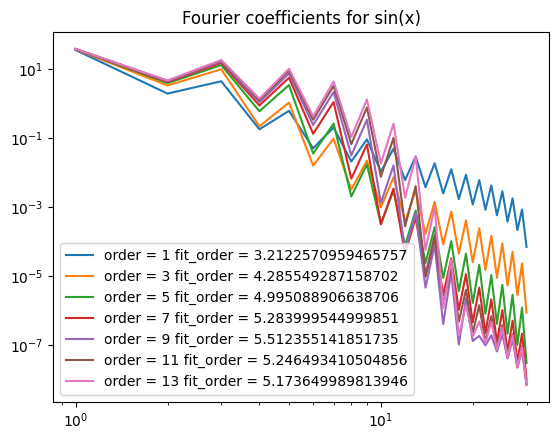

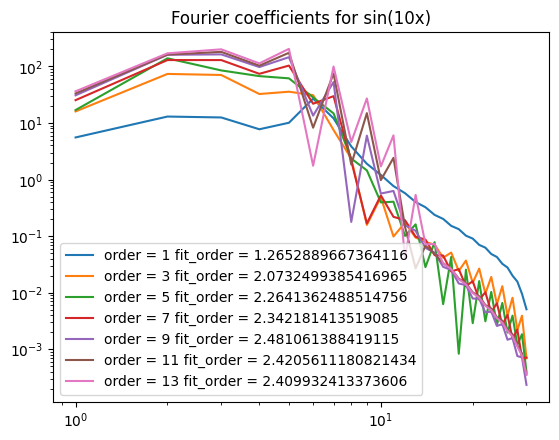

In [55]:
x = np.linspace(0, 2, 32)
fs = [np.exp(x), np.exp(5*x), np.sin(x), np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

if 0:
    for f, n in zip(fs, ns): 
        plt.title(f"Fourier coefficients for {n}") 
        plt.yscale("log") 
        for order in [1, 3, 5, 7, 9, 11, 13]: 
            shift, C, xeval = getShiftFunction(f, order, x)
            hom = f - shift 
            ext = antisymmetricExtension(hom)
            fhat = scipy.fft.fft(ext) 
            plt.plot(np.abs(fhat), label=f"order = {order}") 
        plt.legend()
        plt.show() 


for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    for order in [1, 3, 5, 7, 9, 11, 13]: 
        shift, C, xeval = getShiftFunction(f, order, x)
        hom = f - shift 
        ext = antisymmetricExtension(hom)
        fhat = scipy.fft.fft(ext) 
        y    = np.abs(fhat)[1:int(len(fhat)/2)]
        r    = np.arange(1, len(y)+1)
        #print(len(y), len(r))
        def fitfunc(x, beta): 
            return np.log(y[0]) + beta * np.log(x)
        coeff, cov = scipy.optimize.curve_fit(fitfunc, r, np.log(y)) 
        #print(coeff)
        plt.loglog(r, y, label=f"order = {order} fit_order = {np.abs(coeff[0])}") 
        #plt.loglog(r, np.exp(fitfunc(r, coeff[0])), label=f"fit with {y[0]} * x ** {coeff[0]}") 
    plt.legend()
    plt.show() 

In [31]:
x = np.linspace(0, 1, 100)
y = x
def fitfunc(x, alpha, beta): 
    return alpha*x**beta
coeff, cov = scipy.optimize.curve_fit(fitfunc, x, y)

In [32]:
coeff

array([1., 1.])